# Jupyter lab server on a GPU node
This manual helps you in running the Swansea Sunbird on GPU (multiple GPU) node.

Note: we are doing this on `lustre` partition. So if you plan to do it on `scratch` partition then remember to change the directory in the job file. Also, copy job file to correct partition.

Forget whatever you did for the Login node. Just Install `Jupyter-lab` as follows.
* Jupyter lab: `pip install jupyterlab`
* Jupyter: `pip install notebook`

Try to setup a password as follows:
```sh
(ml) [s.1915438@sl2 ~]$ jupyter-lab --generate-config
(ml) [s.1915438@sl2 ~]$ jupyter-lab password
Enter password: 
Verify password: 
```
If you get an error while setting up the password. Try using VS Code's extention. I've a seperate tutorial for that. Otherwise, you can work with the token generated by the Jupyter server to open Jupyter-lab in the browser.

# Job Script

Instead of editing the config file we will mention the preferred port in the Job script. An ip of 0.0.0.0 means that anyone in that local network can access the Jupyter-lab at localhost (127.0.0.1) if they know the port and the token/password. 

Create a new file `jupyter.sh`.
```sh
[s.1915438@sl1 ~]$ cat jupyter.sh 
#!/bin/bash
#SBATCH --nodes 1
#SBATCH --cpus-per-task 5
#SBATCH --time 03:00:00
#SBATCH --ntasks=1
#SBATCH --job-name jupyter-lab
#SBATCH -o /home/s.1915438/jupyter_log/jupyter-lab-%J.log
#SBATCH -e /home/s.1915438/jupyter_log/jupyter-lab-%J.log
#SBATCH --gres=gpu:1
#SBATCH --account=scw1901
#SBATCH --partition=accel_ai

# get tunneling info

port=8888
node=$(hostname -s)
user=$(whoami)


# run jupyter notebook
module load anaconda/3
source activate ml
jupyter-lab --no-browser --port=${port} --ip=${node}

```

Copy this file to home directory `~` or `/home/s.1915438` using VS code or Filezilla or even using the Jupyter lab on login node.

# Node number
Type this submit your job.
```sh
[s.1915438@sl1 ~]$ sbatch jupyter.sh 
Submitted batch job 7141842
```

You can see your Job in `squeue` as follows. Otherwise, there is an error.
```sh
[s.1915438@sl1 ~]$ squeue --user=s.1915438
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7141842  accel_ai jupyter- s.191543  R       6:06      1 scs2041
```

Here the `NODELIST(REASON)` is `scs2041`. In this manual we will refer to this as `<node>`.

# What if someone is already using port 8888 on Sunbird or your local PC?
This usually happens on Sunbird. This is where the log files that we stored proves to be useful. Remember, we saved the log files in the Job script as `home/s.1915438/jupyter_log/jupyter-lab-%J.log`.

So, head on to the directory.

```sh
[s.1915438@sl2 ~]$ cd jupyter_log/
```
Type `ls -l` and see the latest log file that has been created. Try to recall the time when you submitted the job as `sbatch jupyter.sh `. 

```sh
[s.1915438@sl2 jupyter_log]$ ls -l
total 40
-rw-rw-r--. 1 s.1915438 s.1915438 2711 Mar 20 00:54 jupyter-lab-7141842.log
-rw-rw-r--. 1 s.1915438 s.1915438 4262 Mar 20 01:32 jupyter-lab-7141914.log
-rw-rw-r--. 1 s.1915438 s.1915438 6203 Mar 21 07:44 jupyter-lab-7147707.log
-rw-rw-r--. 1 s.1915438 s.1915438 2050 Mar 21 17:52 jupyter-lab-7147898.log
-rw-rw-r--. 1 s.1915438 s.1915438 2739 Mar 21 17:59 jupyter-lab-7147899.log
-rw-rw-r--. 1 s.1915438 s.1915438  815 Mar 21 18:11 jupyter-lab-7147901.log
-rw-rw-r--. 1 s.1915438 s.1915438 4687 Mar 21 18:56 jupyter-lab-7147902.log
```
Open the newest log file as `cat jupyter-lab-7147902.log`. Here, you will see the output when the Job was submitted.

```sh
[s.1915438@sl2 jupyter_log]$ cat jupyter-lab-7147902.log 
[I 2022-03-21 18:20:49.368 ServerApp] jupyterlab | extension was successfully linked.
[I 2022-03-21 18:20:50.245 ServerApp] nbclassic | extension was successfully linked.
[I 2022-03-21 18:20:50.320 ServerApp] nbclassic | extension was successfully loaded.
[I 2022-03-21 18:20:50.321 LabApp] JupyterLab extension loaded from /home/s.1915438/.conda/envs/modulus/lib/python3.6/site-packages/jupyterlab
[I 2022-03-21 18:20:50.321 LabApp] JupyterLab application directory is /lustrehome/home/s.1915438/.conda/envs/modulus/share/jupyter/lab
[I 2022-03-21 18:20:50.326 ServerApp] jupyterlab | extension was successfully loaded.
[I 2022-03-21 18:20:50.327 ServerApp] The port 8888 is already in use, trying another port.
[I 2022-03-21 18:20:50.327 ServerApp] Serving notebooks from local directory: /lustrehome/home/s.1915438
[I 2022-03-21 18:20:50.327 ServerApp] Jupyter Server 1.13.1 is running at:
[I 2022-03-21 18:20:50.327 ServerApp] http://scs2042:8889/lab
[I 2022-03-21 18:20:50.327 ServerApp]  or http://127.0.0.1:8889/lab
[I 2022-03-21 18:20:50.327 ServerApp] Use Control-C to stop this server and shut down all kernels (twice to skip confirmation).
```

If you carefully read this file. It says `The port 8888 is already in use, trying another port.` And then it says it is using port `8889`. This is something, we should always check. Now while port forwarding using ssh change the `<jupyter_server_port>` in `<localport>:<Node>:<jupyter_server_port>`.

There might be situation when the local port `8888` is not available. Here is one such example when I am already running a local jupyter server on port `8888`.
    
```sh
(base) hell@Dell-Precision-T1600:~$ ssh -N -L 8888:scs2041:8888 s.1915438@sunbird.swansea.ac.uk
bind [127.0.0.1]:8888: Address already in use
^C(base) hell@Dell-Precision-T1600:~$ 
```
    
In this case, simply change the `<localport>` to something else, like `8889` or `8885`.

# Running Jupyter lab on local PC usign ssh tunnel
In your local terminal type this:

`ssh -N -L <port>:<node>:<port> <user>@<server>`
 
In our case, we will use this command.
    
`ssh -N -L 8888:scs2041:8888 s.1915438@sunbird.swansea.ac.uk`
    
Remember, this is the format for port forwarding `<localport>:<Node>:<jupyter_server_port>`. You should always check the `<jupyter_server_port>` in the log files and switch to another port if a particular `<localport>` is not available.

The downside of this command is it doesn't print the token in case you could not set up the password.
```sh
(base) hell@Dell-Precision-T1600:~/Desktop/sunbird transfer/Jupyter lab$ ssh -N -L 8888:scs2041:8888 s.1915438@sunbird.swansea.ac.uk


```
Open you browser, navigate to this address `http://localhost:8888/` assuming port forwarding was successful with `<localport>` as `8888`. It will ask for token/password. If you were able to setup a password then just type it here. Otherwise, for obtaining the token, simply, open the latest log file and copy the token.

## Killing a process that is using port 8888 on local PC
This is an alternative. It would be great if you could simply ignore the used ports.

```sh
(base) hell@Dell-Precision-T1600:~/Desktop/sunbird transfer/Jupyter lab$ ssh -N -L 8888:scs2041:8888 s.1915438@sunbird.swansea.ac.uk
bind [127.0.0.1]:8888: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 8888
Could not request local forwarding.
```

Then we need to kill that process which is using the port `8888` using this trick https://askubuntu.com/a/671337/1230667.


Simply do this.
```sh
(base) hell@Dell-Precision-T1600:~/Desktop/sunbird transfer/Jupyter lab$ ss -ltp | grep 8888
LISTEN    1         128              127.0.0.1:8888              0.0.0.0:*       users:(("ssh",pid=111566,fd=5))                                                
LISTEN    0         128                  [::1]:8888                 [::]:*       users:(("ssh",pid=111566,fd=4))                                                
(base) hell@Dell-Precision-T1600:~/Desktop/sunbird transfer/Jupyter lab$ lsof -ti:8888 | xargs kill -9
(base) hell@Dell-Precision-T1600:~/Desktop/sunbird transfer/Jupyter lab$ ss -ltp | grep 8888
(base) hell@Dell-Precision-T1600:~/Desktop/sunbird transfer/Jupyter lab$ 
```

# Some screenshots
You can run multiple ssh sessions simultaneously to the same server.

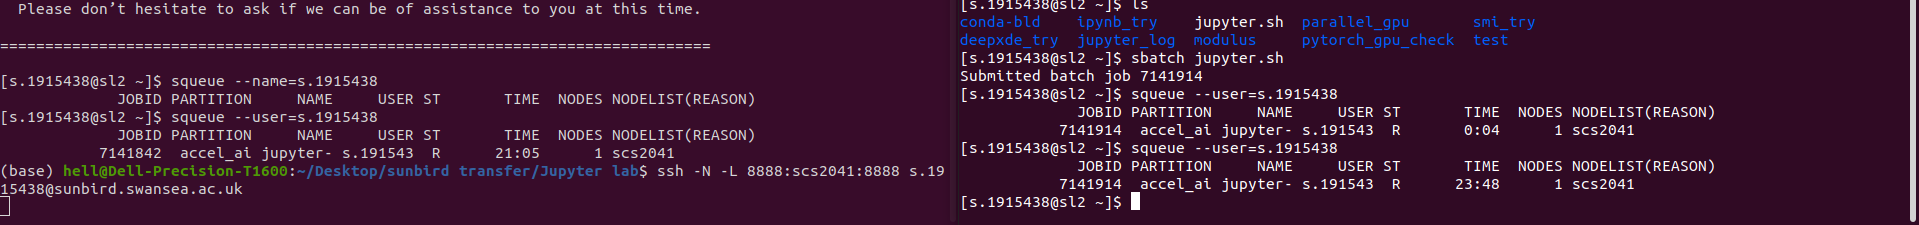

You can see output of `nvidia-smi`

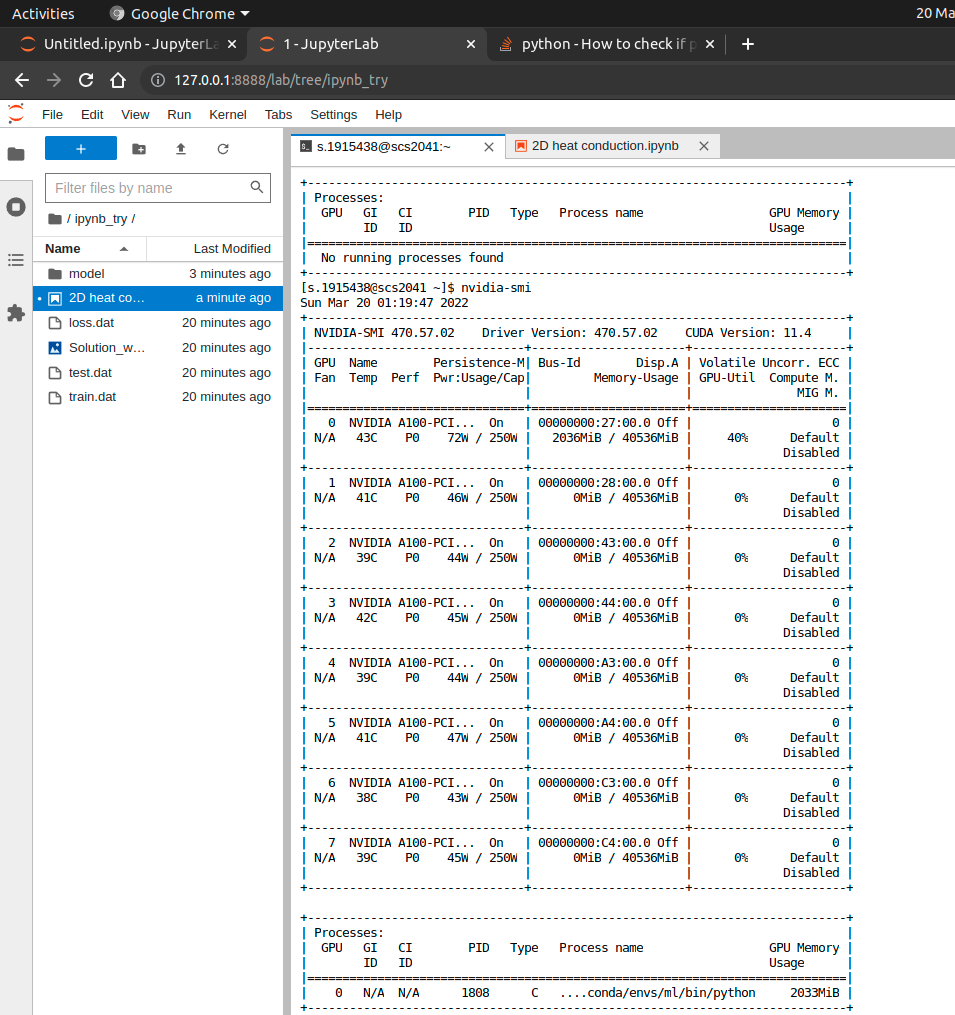

I can run these commands inside the IronPython Notebook.

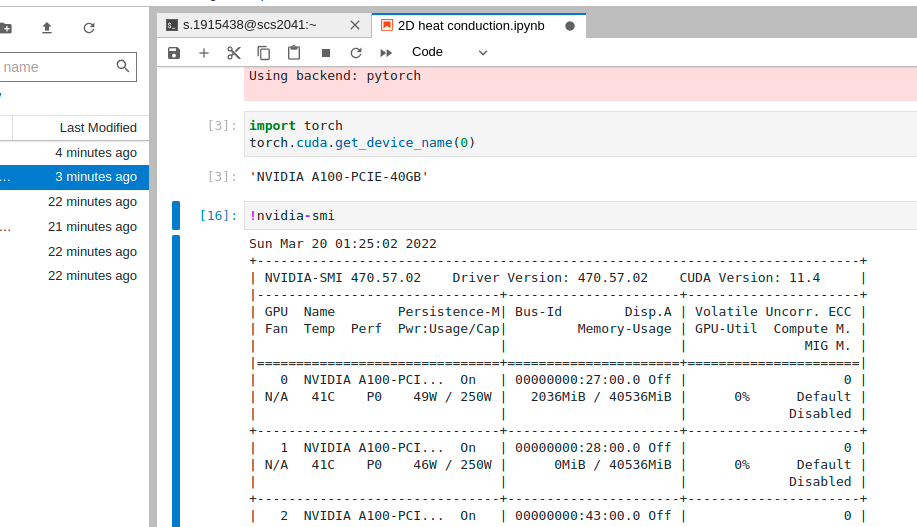

I can train the model inside a cell.

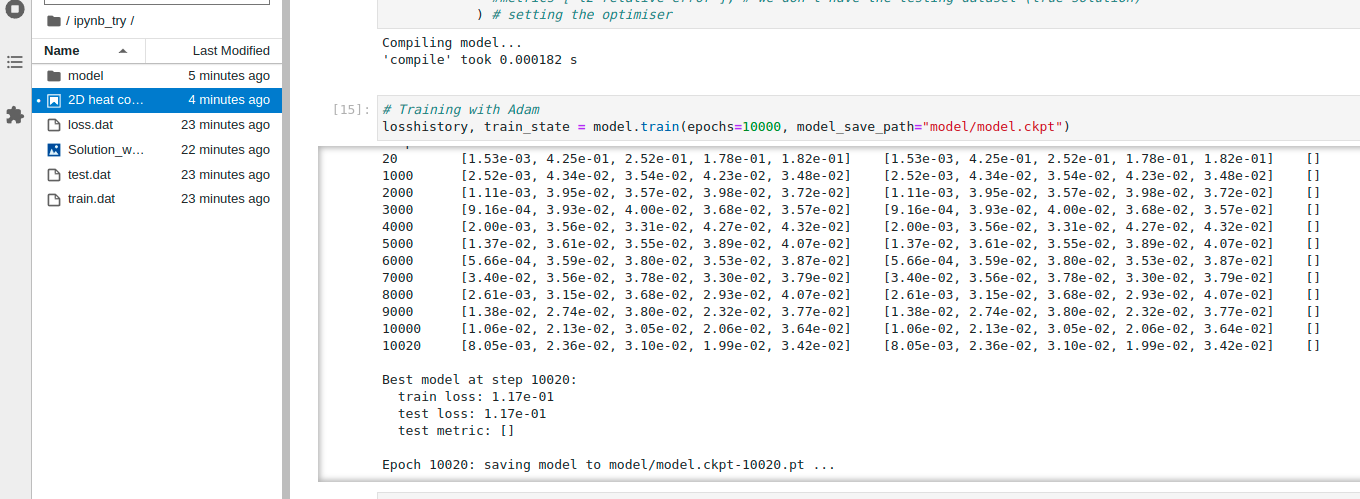

Most important, I can plot and visualise. I can debug or modify my code without the need to submit the job every single.

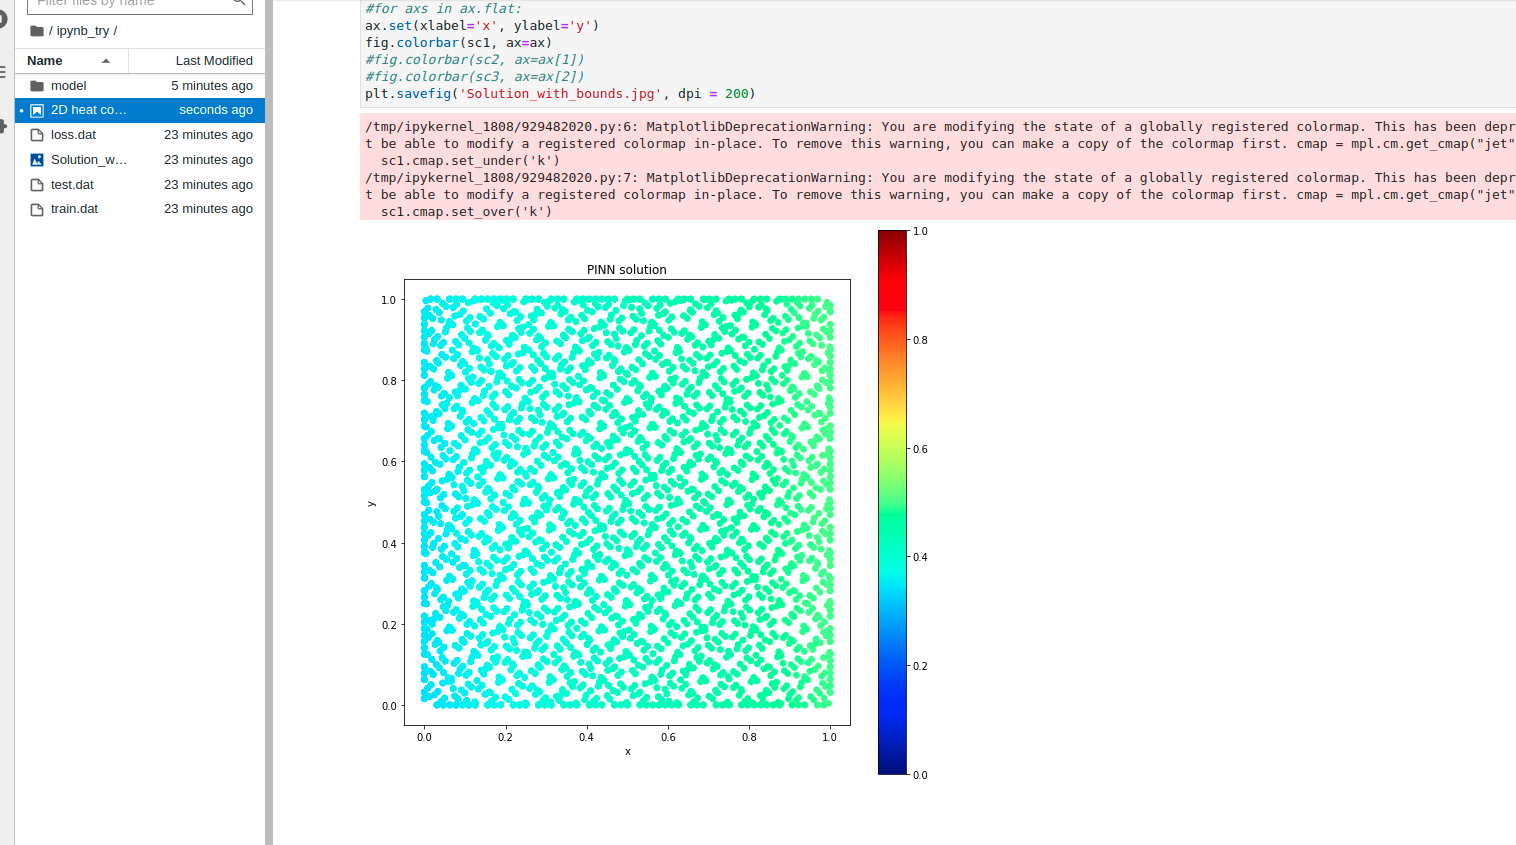